In [1]:
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

In [2]:
transactions = pd.read_csv("../data/transactions_train.csv")
transactions.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


### Feature Selection

#### Encode categorical values

In [3]:
type_encoder = LabelEncoder()
type_names = transactions["type"].unique()
type_encoder.fit(type_names)
type_encoder.classes_ = np.append(type_encoder.classes_, "<unknown>")
transactions["type"]     = type_encoder.transform(transactions["type"])

transactions

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,3,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,1,3,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,1,4,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,1,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
4,1,3,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
6351188,699,4,162326.52,C1557504343,162326.52,0.00,C404511346,0.00,0.00,1
6351189,699,1,162326.52,C1532317723,162326.52,0.00,C446134087,0.00,162326.52,1
6351190,699,4,2763398.31,C577803442,2763398.31,0.00,C619602282,0.00,0.00,1
6351191,699,1,2763398.31,C1491503658,2763398.31,0.00,C454424230,339515.35,3102913.66,1


In [4]:
print("Fraud: {:.2f}%".format(len(transactions[transactions["isFraud"] == 1])/len(transactions)*100))
print("Non-fraud: {:.2f}%".format(len(transactions[transactions["isFraud"] == 0])/len(transactions)*100))

Fraud: 0.12%
Non-fraud: 99.88%


#### Correlation Matrix (Balanced dataset)

Distribution of the classes in the subsample dataset
0    0.5
1    0.5
Name: isFraud, dtype: float64


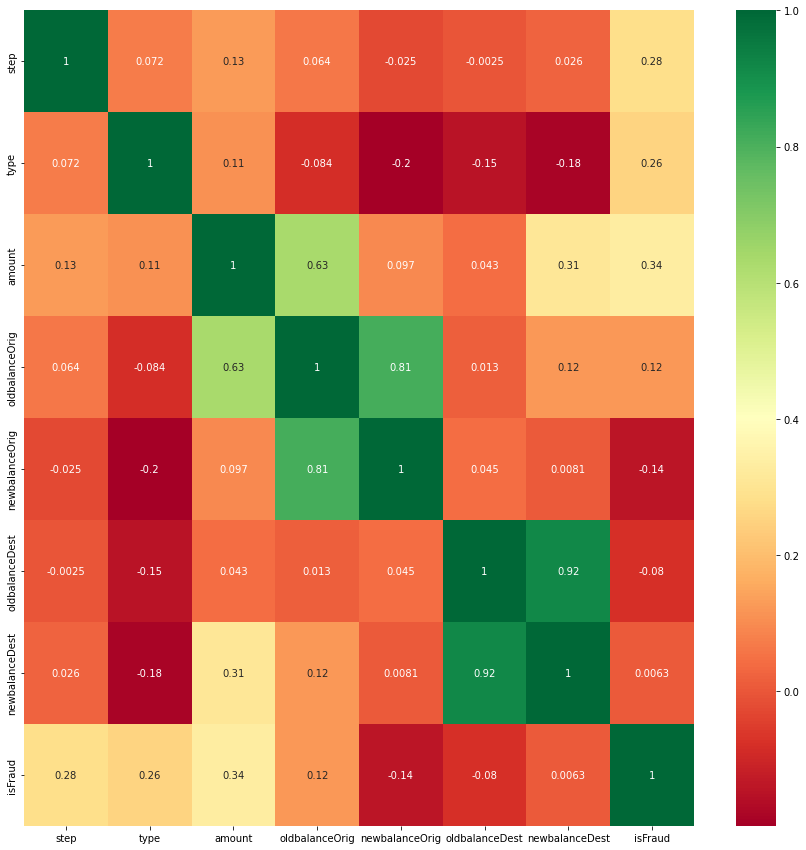

In [5]:
df = transactions.sample(frac=1)
fraud_df = df.loc[df['isFraud'] == 1]
non_fraud_df = df.loc[df['isFraud'] == 0][:len(fraud_df)]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
new_df = normal_distributed_df.sample(frac=1)

print("Distribution of the classes in the subsample dataset")
print(new_df["isFraud"].value_counts()/len(new_df))
plt.figure(figsize=(15,15))
g = sns.heatmap(new_df.corr(), annot=True, cmap="RdYlGn")

In [6]:
# K-Best features using chi2
from sklearn.feature_selection import SelectKBest, chi2

X = new_df.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1)
Y = new_df["isFraud"]

bestfeatures = SelectKBest(score_func=chi2, k=7)
fit = bestfeatures.fit(X, Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ["Feature", "Score"]
print(featureScores.nlargest(7, "Score"))

          Feature         Score
2          amount  7.360185e+09
4  newbalanceOrig  3.629775e+09
3  oldbalanceOrig  1.926353e+09
5  oldbalanceDest  1.345239e+09
6  newbalanceDest  7.162132e+06
0            step  1.366909e+05
1            type  1.048045e+03


### Train-test split

In [7]:
transactions = pd.read_csv("../data/transactions_train.csv")
X = transactions[["type", "amount", "oldbalanceOrig", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]]
Y = transactions["isFraud"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

print("y_train Fraud: {:.2f}%".format(y_train.value_counts()[0]/len(y_train)*100))
print("y_train Non-fraud: {:.2f}%".format(y_train.value_counts()[1]/len(y_train)*100))
print("y_test Fraud: {:.2f}%".format(y_test.value_counts()[0]/len(y_test)*100))
print("y_test Non-fraud: {:.2f}%".format(y_test.value_counts()[1]/len(y_test)*100))

y_train Fraud: 99.88%
y_train Non-fraud: 0.12%
y_test Fraud: 99.87%
y_test Non-fraud: 0.13%


In [8]:
kf = KFold(n_splits=10, shuffle=True)

results = {
    "Fold": [],
    "Accuracy": [],
    "F1-Score": [],
    "TP": [],
    "FP": [],
    "FN": [],
    "TN": [],
}

fold = 0
for train_index, test_index in kf.split(X_train):
    print("Fold {}".format(fold))
    X_train_split, X_test_split = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_split, y_test_split = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Encode types
    type_encoder = LabelEncoder()
    type_names = X_train_split["type"].unique()
    type_encoder.fit(type_names)
    type_encoder.classes_ = np.append(type_encoder.classes_, "<unknown>")
    X_train_split["type"] = type_encoder.transform(X_train_split["type"])
    
    # Normalize
    scaler = StandardScaler()
    X_train_split = scaler.fit_transform(X_train_split)
    
    print("Distribution of y_train set BEFORE balancing: {}", Counter(y_train_split))
    
    under = RandomUnderSampler(sampling_strategy=0.002)
    X_train_split, y_train_split = under.fit_resample(X_train_split, y_train_split)
    
    print("Distribution of y_train set AFTER balancing: {}", Counter(y_train_split))
    
    # model = LogisticRegression()
    model = MLPClassifier(hidden_layer_sizes=(8,16,16,8), max_iter=50, alpha=1e-5, solver='adam')
    model = model.fit(X_train_split, y_train_split)
    
    # Encode type
    X_test_split.loc[~X_test_split.type.isin(type_encoder.classes_), 'type'] = "<unknown>"
    X_test_split["type"] = type_encoder.transform(X_test_split["type"])
    
    X_test_split = scaler.transform(X_test_split)
    predictions = model.predict(X_test_split)
    
    f1score = f1_score(y_test_split, predictions).round(4)
    accuracy = accuracy_score(y_test_split, predictions).round(4)
    tn, fp, fn, tp = confusion_matrix(y_test_split, predictions).ravel()
    
    results["Fold"].append(fold)
    
    results["Accuracy"].append(accuracy)
    results["F1-Score"].append(f1score)
    results["TP"].append(tp)
    results["FP"].append(fp)
    results["FN"].append(fn)
    results["TN"].append(tn)
    
    fold += 1

results_df = pd.DataFrame(results)
results_df

Fold 0


/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_split["type"] = type_encoder.transform(X_train_split["type"])


Distribution of y_train set BEFORE balancing: {} Counter({0: 4567316, 1: 5542})
Distribution of y_train set AFTER balancing: {} Counter({0: 2771000, 1: 5542})


/Users/gabriel/anaconda3/envs/plentina/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_split["type"] = type_encoder.transform(X_test_split["type"])


Fold 1


/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_split["type"] = type_encoder.transform(X_train_split["type"])


Distribution of y_train set BEFORE balancing: {} Counter({0: 4567383, 1: 5475})
Distribution of y_train set AFTER balancing: {} Counter({0: 2737500, 1: 5475})


/Users/gabriel/anaconda3/envs/plentina/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_split["type"] = type_encoder.transform(X_test_split["type"])


Fold 2


/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_split["type"] = type_encoder.transform(X_train_split["type"])


Distribution of y_train set BEFORE balancing: {} Counter({0: 4567378, 1: 5480})
Distribution of y_train set AFTER balancing: {} Counter({0: 2740000, 1: 5480})


/Users/gabriel/anaconda3/envs/plentina/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_split["type"] = type_encoder.transform(X_test_split["type"])


Fold 3


/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_split["type"] = type_encoder.transform(X_train_split["type"])


Distribution of y_train set BEFORE balancing: {} Counter({0: 4567361, 1: 5497})
Distribution of y_train set AFTER balancing: {} Counter({0: 2748500, 1: 5497})


/Users/gabriel/anaconda3/envs/plentina/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_split["type"] = type_encoder.transform(X_test_split["type"])


Fold 4


/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_split["type"] = type_encoder.transform(X_train_split["type"])


Distribution of y_train set BEFORE balancing: {} Counter({0: 4567366, 1: 5493})
Distribution of y_train set AFTER balancing: {} Counter({0: 2746500, 1: 5493})


/Users/gabriel/anaconda3/envs/plentina/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_split["type"] = type_encoder.transform(X_test_split["type"])


Fold 5


/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_split["type"] = type_encoder.transform(X_train_split["type"])


Distribution of y_train set BEFORE balancing: {} Counter({0: 4567372, 1: 5487})
Distribution of y_train set AFTER balancing: {} Counter({0: 2743500, 1: 5487})


/Users/gabriel/anaconda3/envs/plentina/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_split["type"] = type_encoder.transform(X_test_split["type"])


Fold 6


/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_split["type"] = type_encoder.transform(X_train_split["type"])


Distribution of y_train set BEFORE balancing: {} Counter({0: 4567340, 1: 5519})
Distribution of y_train set AFTER balancing: {} Counter({0: 2759500, 1: 5519})


/Users/gabriel/anaconda3/envs/plentina/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_split["type"] = type_encoder.transform(X_test_split["type"])


Fold 7


/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_split["type"] = type_encoder.transform(X_train_split["type"])


Distribution of y_train set BEFORE balancing: {} Counter({0: 4567360, 1: 5499})
Distribution of y_train set AFTER balancing: {} Counter({0: 2749500, 1: 5499})


/Users/gabriel/anaconda3/envs/plentina/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_split["type"] = type_encoder.transform(X_test_split["type"])


Fold 8


/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_split["type"] = type_encoder.transform(X_train_split["type"])


Distribution of y_train set BEFORE balancing: {} Counter({0: 4567350, 1: 5509})
Distribution of y_train set AFTER balancing: {} Counter({0: 2754500, 1: 5509})


/Users/gabriel/anaconda3/envs/plentina/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_split["type"] = type_encoder.transform(X_test_split["type"])


Fold 9


/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_split["type"] = type_encoder.transform(X_train_split["type"])


Distribution of y_train set BEFORE balancing: {} Counter({0: 4567343, 1: 5516})
Distribution of y_train set AFTER balancing: {} Counter({0: 2758000, 1: 5516})


/Users/gabriel/anaconda3/envs/plentina/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/var/folders/kq/k1pk_jnj2jl60rmdl3b6b51w0000gn/T/ipykernel_50196/4125503518.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_split["type"] = type_encoder.transform(X_test_split["type"])


,Fold,Accuracy,F1-Score,TP,FP,FN,TN
0,0,0.9996,0.8180,409,20,162,507505
1,1,0.9996,0.8262,473,34,165,507424
2,2,0.9995,0.7507,414,56,219,507407
3,3,0.9995,0.7740,411,35,205,507445
4,4,0.9995,0.7594,385,9,235,507466
5,5,0.9996,0.8000,430,19,196,507450
6,6,0.9995,0.7647,416,78,178,507423
7,7,0.9993,0.7158,452,197,162,507284
8,8,0.9996,0.8276,444,25,160,507466
9,9,0.9996,0.8219,427,15,170,507483


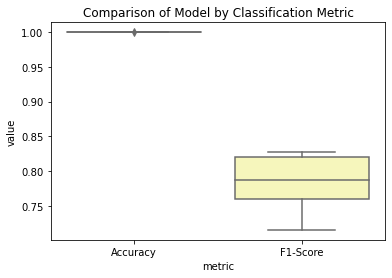

In [9]:
res = pd.melt(results_df, var_name='metric', value_vars=['Accuracy', 'F1-Score'])
g = sns.boxplot(x="metric", y="value", data=res, palette="Set3")
plt.title('Comparison of Model by Classification Metric')
plt.show()

### Evaluate

In [10]:
transactions = pd.read_csv("../data/transactions_train.csv")
X = transactions[["type", "amount", "oldbalanceOrig", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]]
Y = transactions["isFraud"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [11]:
# Encode types
type_encoder = LabelEncoder()
type_names = X_train["type"].unique()
type_encoder.fit(type_names)
type_encoder.classes_ = np.append(type_encoder.classes_, "<unknown>")
X_train["type"] = type_encoder.transform(X_train["type"])

# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

print("Distribution of y_train set BEFORE balancing: {}", Counter(y_train))
under = RandomUnderSampler(sampling_strategy=0.002)
X_train, y_train = under.fit_resample(X_train, y_train)
print("Distribution of y_train set AFTER balancing: {}", Counter(y_train))

Distribution of y_train set BEFORE balancing: {} Counter({0: 5074748, 1: 6206})
Distribution of y_train set AFTER balancing: {} Counter({0: 3103000, 1: 6206})


In [12]:
model = MLPClassifier(hidden_layer_sizes=(8,16,16,8), max_iter=50, alpha=1e-5, solver='adam')
model = model.fit(X_train, y_train)

In [13]:
# Encode test types
X_test.loc[~X_test.type.isin(type_encoder.classes_), 'type'] = "<unknown>"
X_test["type"] = type_encoder.transform(X_test["type"])

In [14]:
X_test = scaler.transform(X_test)

In [15]:
predictions = model.predict(X_test)

f1score = f1_score(y_test, predictions).round(4)
accuracy = accuracy_score(y_test, predictions).round(4)
cm = confusion_matrix(y_test,predictions)

print("F1Score: {}".format(f1score))
print("Accuracy: {}".format(accuracy))

cmtx = pd.DataFrame(cm, index=['True (Y)', 'True (N)'], columns=['Prediction (Y)', 'Prediction: (N)'])
cmtx

F1Score: 0.8266
Accuracy: 0.9996


,Prediction (Y),Prediction: (N)
True (Y),1268659,69
True (N),398,1113


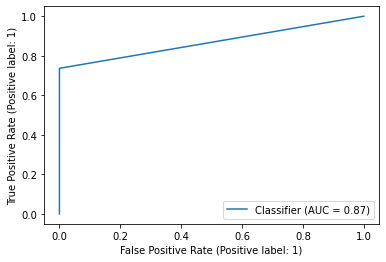

In [16]:
RocCurveDisplay.from_predictions(y_test, predictions)
plt.show()

### Store Artifacts

In [17]:
def dump_artifact(artifact, artifact_path):
    with open(artifact_path, 'wb') as handle:
        pickle.dump(artifact, handle, protocol=pickle.HIGHEST_PROTOCOL)

artifacts = {
    "type_encoder": type_encoder,
    "model": model,
    "scaler": scaler
}
dump_artifact(artifacts, "../artifacts/artifacts.pkl")